# Intro

It's the last time we meet in class for exercises! And to celebrate this mile-stone, we've put together an amazing set of exercises. And if you're behind, don't worry. The workload is low!

  - Part A: First, we play around with sentiment analysis
  - Part B **(optional)**: We study paths in networks using a fun new dataset. (If only doing part A feels too easy for you, I've added a really fun exercise that should be fun and challenging.)

But first, watch this video that touches upon your final project and Assignment 2 (which will be released later Wednesday),

> [**Video**](https://www.dropbox.com/scl/fi/jh3490oqnqh4yl629ik09/ProjectAndAssigment.mp4?rlkey=2uyl7tq0xgzydl5u8pqzncf92&dl=0) about the Independent Project and Assignment 2

# Part A: Sentiment analysis

Sentiment analysis is another highly useful technique which we'll use to make sense of the Wiki
data. Further, experience shows that it might well be very useful when you get to the project stage of the class.


> [**Video Lecture**](https://www.dropbox.com/scl/fi/u0rn767hg7e6ue4ryx41a/Sentiment.mp4?rlkey=4kwfqv6pkw1aijshm5zqe8ehh&dl=0): Sentiment and dictionary-based methods.



> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 


_Exercise 1_: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).


In [78]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import networkx as nx
import nltk
import numpy as np
import os
import pandas as pd
import pickle as pkl
import re
import string

In [79]:
# Extracting words and sentiment scores from the data into a dictionary
word_sentiment_dict = {}
with open("../lectures/dataset_s1.txt", "r") as file:
    lines = file.readlines()

# Skipping the header line
for line in lines[1:]:  
    
    # Reading separate columns split by tab character
    tokens = line.split("\t")

    # Reading the word and corresponding sentiment score into the dict
    word = tokens[0]
    sentiment = float(tokens[2])
    word_sentiment_dict[word] = sentiment

In [40]:
from nltk import FreqDist

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Get sentiment of a text using FreqDist for speed up
def get_sentiment_for_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Filter out stopwords and non-alphabetic tokens
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    
    # Lemmatize and lowercase tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in filtered_tokens]
    
    # Create a frequency distribution of tokens
    freq_dist = FreqDist(lemmatized_tokens)
    
    total_sentiment = 0
    total_weight = 0
    
    # For each unique token, find its sentiment and then its weighted contribution
    for token, freq in freq_dist.items():
        if token in word_sentiment_dict:
            total_sentiment += word_sentiment_dict[token] * freq  # Multiply by frequency for weighting
            total_weight += freq
    
    # Return the weighted average sentiment if total_weight is not zero; otherwise, return None
    return total_sentiment / total_weight if total_weight != 0 else None

> * Iterate over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property. 

In [41]:
# ../rappers_text was created in week 6 

# Calculate and store sentiment for every tokenized rapper page

# Get each rapper file by the rapper name
# URL of the CSV file
rappers_url = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2023/main/files/Rappers.csv'

# Reading the CSV file into a pandas DataFrame
df_rappers = pd.read_csv(rappers_url)
rapper_file_root = 'rappers_text/'
file_list = [f"{re.sub(r'[^a-zA-Z0-9_]', '_', rapper_name)}.txt" for rapper_name in df_rappers['WikipediaPageName']]

# Dictionary to store sentiment values for each rapper
rapper_sentiments = {}
# Iterate over each file and calculate sentiment
for rapper_file_name in file_list:
    with open(os.path.join(rapper_file_root, rapper_file_name), 'r', encoding='utf-8') as file:
        # Read file text to a string
        content = file.read()
        # Calculate the sentiment for the file text
        sentiment = get_sentiment_for_text(content)
        
        rapper_sentiments[rapper_file_name] = sentiment

# Checking the first few sentiment values
list(rapper_sentiments.items())[:5]

[('6ix9ine.txt', 5.455729001584785),
 ('9th_Prince.txt', 5.457936507936509),
 ('22Gz.txt', 5.545100000000002),
 ('38_Spesh.txt', 5.690217391304348),
 ('The_45_King.txt', 5.619158751696067)]

In [42]:
# Loop through network and add sentiment as nodal property

# Importing the Graph saved in Week 4's exercises
rapper_network = pkl.load(open('rapper_network.pkl', 'rb'))
rapper_network_with_sentiment = rapper_network.copy()

def add_sentiment_to_nodes(network, file_list):
    for node in network.nodes():
        # Generate filename from the node
        filename = f"{re.sub(r'[^a-zA-Z0-9_]', '_', node)}.txt"
        
        # Check if the file for the rapper exists in the list
        if filename in file_list:
            filepath = os.path.join(rapper_file_root, filename)
            
            try:
                with open(filepath, 'r', encoding='utf-8') as file:
                    content = file.read()

                    # Check if the content is empty
                    if not content.strip():
                        print(f"File {filepath} is empty.")
                        # subsequent code will be skipped for that iteration
                        continue

                    sentiment = get_sentiment_for_text(content)
                    if sentiment is not None:
                        network.nodes[node]['sentiment'] = sentiment
            except FileNotFoundError:
                print(f"File {filepath} not found.")
                continue
        else:
            print(f"File name {filename} not present in file list.")

# Just call the function. Do not reassign the result.
add_sentiment_to_nodes(rapper_network_with_sentiment, file_list)

# Now, this will work
print(rapper_network_with_sentiment.nodes(data=True))

File rappers_text/G_Nut.txt is empty.
File rappers_text/G_Stack.txt is empty.
File rappers_text/Mugzi.txt is empty.
File rappers_text/Stressmatic.txt is empty.
File rappers_text/V_White.txt is empty.
[('24kGoldn', {'coast': 'West', 'sentiment': 5.906948640483387}), ('40 Glocc', {'coast': 'West', 'sentiment': 5.444404536862013}), ('DJ A-Tron', {'coast': 'West', 'sentiment': 5.966887755102039}), ('Ab-Soul', {'coast': 'West', 'sentiment': 5.737441509433963}), ('Abstract Rude', {'coast': 'West', 'sentiment': 5.624358353510892}), ('Aceyalone', {'coast': 'West', 'sentiment': 5.585031446540881}), ('Afroman', {'coast': 'West', 'sentiment': 5.714676007005252}), ("Ak'Sent", {'coast': 'West', 'sentiment': 5.792477064220183}), ('The Alchemist (musician)', {'coast': 'West', 'sentiment': 5.71089201877934}), ('B-Legit', {'coast': 'West', 'sentiment': 5.508348017621147}), ('B-Real', {'coast': 'West', 'sentiment': 5.5946166394779775}), ('B.G. Knocc Out', {'coast': 'West', 'sentiment': 5.740735294117645

> * Remember histograms? Create a histogram of all character's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2).

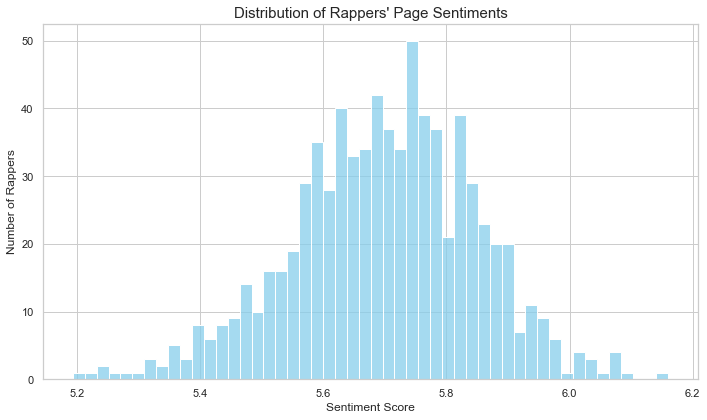

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plot
sns.set(style="whitegrid")

# Extract sentiment values from rapper_sentiments dictionary
sentiments = list(rapper_sentiments.values())

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.histplot(sentiments, bins=50, color='skyblue')

# Set title and labels
plt.title('Distribution of Rappers\' Page Sentiments', fontsize=15)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Number of Rappers', fontsize=12)

# Display the histogram
plt.tight_layout()
plt.show()

> * Who are the 10 rappers with happiest and saddest pages?

<!---
> * Now we average the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected characters. 
>   - What are the three happiest communities? 
>   - what are the three saddest communities?
>   - Do these results confirm what you can learn about each community by skimming the wikipedia pages?
--->

**Note**: Calculating sentiment takes a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

In [50]:
# Filter out rappers with None sentiment
filtered_rapper_sentiments = {rapper: sentiment for rapper, sentiment in rapper_sentiments.items() if sentiment is not None}

# Sort the filtered rappers dict by sentiment scores
sorted_rapper_sentiment = sorted(filtered_rapper_sentiments.items(), key=lambda x: x[1], reverse=True)

happiest_rapper_pages = sorted_rapper_sentiment[:10] 
saddest_rapper_pages = sorted_rapper_sentiment[-10:]

print("\n10 Rappers with the Happiest Pages:")
for rapper, sentiment in happiest_rapper_pages:
    print(f"{rapper}: {sentiment}")
print("\n")

# Print the results
print("10 Rappers with the Saddest Pages:")
for rapper, sentiment in saddest_rapper_pages[::-1]:
    print(f"{rapper}: {sentiment}")


10 Rappers with the Happiest Pages:
DJ_Webstar.txt: 6.160377358490565
Like__record_producer_.txt: 6.09897435897436
Young_Music_DYMG.txt: 6.080504587155964
D_Smoke.txt: 6.078611111111107
Dave_Free.txt: 6.076942148760329
MC_Yogi.txt: 6.065548387096772
Emcee_N_I_C_E_.txt: 6.044711316397232
Lamiere.txt: 6.0357251908396945
Awkwafina.txt: 6.029999999999998
Roshon_Fegan.txt: 6.02738955823293


10 Rappers with the Saddest Pages:
Slip_Capone.txt: 5.193676470588234
Hell_Rell.txt: 5.225838150289017
Slow_Pain.txt: 5.246370656370658
Droop_E.txt: 5.249597550306212
Ol__Dirty_Bastard.txt: 5.266739702015775
AR_Ab.txt: 5.280030769230766
Killa_Sin.txt: 5.308390804597701
Necro__rapper_.txt: 5.320792540792538
MC_Trouble.txt: 5.325842696629214
Cool_C.txt: 5.326199376947041


*Exercise 2*: West coast and East coast.

Now, let's check if the pages of rappers from different coasts tend to have different sentiment. 

> * First, think about it for a second: Do you expect pages of rappers from different coasts to have different sentiment? Why/why not?
> * Next, Download [this file](https://github.com/SocialComplexityLab/socialgraphs2023/edit/main/files/Rappers.csv) if you do not have it already.
> * Start by plotting the distribution of sentiment for the pages of east-coast and west-coast rappers separately. 

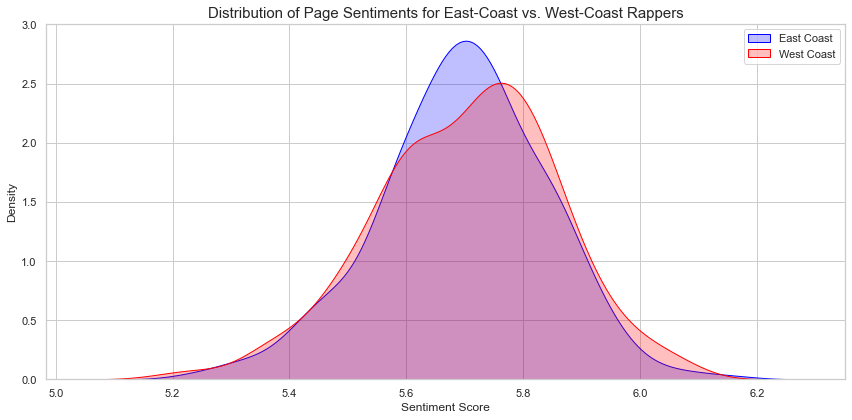

In [61]:
east_coast_rappers = df_rappers[df_rappers['Coast'] == 'East']['WikipediaPageName'].apply(lambda x: f"{re.sub(r'[^a-zA-Z0-9_]', '_', x)}.txt").tolist()
west_coast_rappers = df_rappers[df_rappers['Coast'] == 'West']['WikipediaPageName'].apply(lambda x: f"{re.sub(r'[^a-zA-Z0-9_]', '_', x)}.txt").tolist()

# Get sentiment values for East and West coast rappers
east_coast_sentiments = [rapper_sentiments[rapper] for rapper in east_coast_rappers if rapper in rapper_sentiments and rapper_sentiments[rapper] is not None]
west_coast_sentiments = [rapper_sentiments[rapper] for rapper in west_coast_rappers if rapper in rapper_sentiments and rapper_sentiments[rapper] is not None]

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot sentiment distributions
sns.kdeplot(east_coast_sentiments, fill=True, label='East Coast', color='blue')
sns.kdeplot(west_coast_sentiments, fill=True, label='West Coast', color='red')

# Set title and labels
plt.title('Distribution of Page Sentiments for East-Coast vs. West-Coast Rappers', fontsize=15)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

> * Now calculate the mean, median, 10th percentile, and 90 percentile sentiment value for each coast and indicate those values on the corresponding histograms.
> * Comment on these distributions and how they relate to the overall sentiment distribution you calculated in Exercise 1 above.

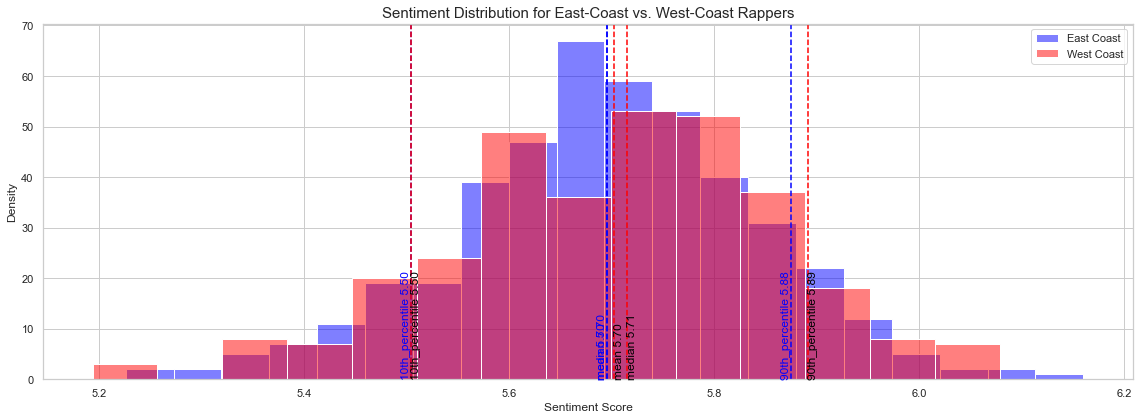

In [67]:
# Calculate statistics for each coast
east_coast_stats = {
    'mean': np.mean(east_coast_sentiments),
    'median': np.median(east_coast_sentiments),
    '10th_percentile': np.percentile(east_coast_sentiments, 10),
    '90th_percentile': np.percentile(east_coast_sentiments, 90)
}

west_coast_stats = {
    'mean': np.mean(west_coast_sentiments),
    'median': np.median(west_coast_sentiments),
    '10th_percentile': np.percentile(west_coast_sentiments, 10),
    '90th_percentile': np.percentile(west_coast_sentiments, 90)
}

# Plotting
plt.figure(figsize=(16, 6))

# East Coast
sns.histplot(east_coast_sentiments, color='blue', label='East Coast', alpha=0.5)
for stat, value in east_coast_stats.items():
    plt.axvline(value, color='blue', linestyle='--')
    plt.text(value, 0.02, f'{stat} {value:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', color='blue')

# West Coast
sns.histplot(west_coast_sentiments, color='red', label='West Coast', alpha=0.5)
for stat, value in west_coast_stats.items():
    plt.axvline(value, color='red', linestyle='--')
    plt.text(value, 0.02, f'{stat} {value:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='left', color='black')

# Title, labels, and legend
plt.title('Sentiment Distribution for East-Coast vs. West-Coast Rappers', fontsize=15)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [57]:
actual_west_sentiment = np.mean(west_coast_sentiments)
np.random.seed(0)  # Seed for reproducibility
all_sentiments = list(rapper_sentiments.values())
shuffled_west_sentiments = []

for _ in range(1000):
    # Shuffle the coast labels while keeping the number of east and west coast rappers the same
    shuffled_labels = np.random.permutation(['east'] * len(east_coast_sentiments) + ['west'] * len(west_coast_sentiments))
    
    # Get the sentiment values corresponding to the shuffled west coast labels
    west_sentiments_in_shuffle = [all_sentiments[i] for i, label in enumerate(shuffled_labels) if label == 'west']
    
    # Calculate and store the mean sentiment
    shuffled_west_sentiments.append(np.mean(west_sentiments_in_shuffle))

c:\Users\pih\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pih\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [59]:
# Calculate the number of times the shuffled values are less or greater than the actual value
less_than_actual = sum(1 for s in shuffled_west_sentiments if s < actual_west_sentiment)
greater_than_actual = sum(1 for s in shuffled_west_sentiments if s > actual_west_sentiment)

# Check against the 5% threshold for both conditions
reject_lower_hypothesis = less_than_actual < 0.05 * 1000
reject_higher_hypothesis = greater_than_actual < 0.05 * 1000

print(reject_lower_hypothesis, reject_higher_hypothesis)

True True


In [71]:
# Filter out rappers with sentiment 0
east_coast_filtered_sentiments = [sentiment for sentiment in east_coast_sentiments if sentiment != 0]
west_coast_filtered_sentiments = [sentiment for sentiment in west_coast_sentiments if sentiment != 0]

# Calculate the average sentiment for each coast
east_coast_avg_sentiment = np.mean(east_coast_filtered_sentiments)
west_coast_avg_sentiment = np.mean(west_coast_filtered_sentiments)

print(f"Average sentiment for East Coast: {east_coast_avg_sentiment:.3f}")
print(f"Average sentiment for West Coast: {west_coast_avg_sentiment:.3f}")

# Determine which coast is the happiest
if east_coast_avg_sentiment > west_coast_avg_sentiment:
    print("The East Coast is the happiest according to the LabMT wordlist approach.")
elif east_coast_avg_sentiment < west_coast_avg_sentiment:
    print("The West Coast is the happiest according to the LabMT wordlist approach.")
else:
    print("Both coasts have the same average sentiment according to the LabMT wordlist approach.")

Average sentiment for East Coast: 5.695
Average sentiment for West Coast: 5.702
The West Coast is the happiest according to the LabMT wordlist approach.


> * Use the "label shuffling technique" that I illustrated in **Week 5, exercise 7** to determine whether or not 
>   1. the west-coast pages tend to have lower sentiment than a similarly sized group of randomly chosen rapper pages (pick random groups 1000 times and reject the hypothesis if 5% of the random outcomes are lower than the actual value observed for the west-coast pages)
>   2. the west-coast pages tend to have higher sentiment than a similarly sized group of randomly chosen character pages (again, use 1000 random draws and a 5% confidence bound).
>   3. (**optional**) Perhaps there are other divisions of rappers whose pages would be more likely to have different sentiment. Perhaps comparing groups of rappers of different sexes, races, etc. would give interesting results? Feel free to do a deep dive here, and let me know which groups you analyze and how you end up "guessing" a rapper's sex, race, etc. 

Comment: The "label shuffling technique" is incredibly useful. It may turn out to be a good tool to apply for your independent project. Keep it in mind.

In [76]:
# Compute the observed difference in means
observed_diff = east_coast_avg_sentiment - west_coast_avg_sentiment

# Create a combined list of all sentiments
combined_sentiments = east_coast_filtered_sentiments + west_coast_filtered_sentiments

# Number of permutations
n_permutations = 10000

# To store differences in means from permutations
permuted_diffs = []

# Permute labels and compute differences in means
for _ in range(n_permutations):
    # Shuffle the combined sentiments
    shuffled_sentiments = np.random.permutation(combined_sentiments)
    
    # Split into two groups: east and west
    shuffled_east = shuffled_sentiments[:len(east_coast_filtered_sentiments)]
    shuffled_west = shuffled_sentiments[len(east_coast_filtered_sentiments):]
    
    # Compute the difference in means
    permuted_diff = np.mean(shuffled_east) - np.mean(shuffled_west)
    permuted_diffs.append(permuted_diff)

# Compute p-value: proportion of times permuted difference is greater than or equal to observed difference
p_value = np.sum(np.abs(permuted_diffs) >= np.abs(observed_diff)) / n_permutations

print(f"p-value: {p_value:.4f}")

p-value: 0.5326


The observed difference in sentiments between coasts is not statistically significant at the 5% level.

- Average the average sentiment of the nodes in each community to find a community-level sentiment.


# Part B (optional): The Wikispeedia Extravaganza

This final **AND OPTIONAL** exercise is about tying everything together. In this context "optional" means that the exercises below will not be on the assignment (but they're fun & cool).

We try to combine our work on networks plus our work on language in order to understand and analyze human behavior. We'll be working on a cool dataset of humans playing a game on (a special version of) wikipedia called "wikispeedia".  Note that the game is now called *The Wiki Game* and can be found at http://thewikigame.com/ ( ... while "http://wikispeedia.org" is a page about GPS coordinates of speed-traps). 

Here's how the game worked:

> In the game, users are asked to navigate from a given _source_ article (e.g. https://en.wikipedia.org/wiki/Gold_dollar) to a given _target_ article (e.g. https://en.wikipedia.org/wiki/Ronald_Reagan), **by only clicking Wikipedia links**. A condensed version of Wikipedia (4,604 articles) is used. 

So this dataset contains **human navigation paths** (clicking from page to page to find a target) and today we will work on this dataset to see if we can use our skills to understand how human navigation works. We will think about the following questions.

* Path lengths
* Betweenness from the human perspective
* What characterizes human paths?

Let's get started.

### Download the dataset

The first thing we're going to do is download the dataset. Today everything related to data is nice, clean, and easy to work with (Yay). You can get the dataset [here](https://snap.stanford.edu/data/wikispeedia.html). You will need to get 

* The list of wiki articles
* The network connections
* The navigation paths
* Plaintext of the wiki articles

### Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths. 

_Optional Exercises 1_
> * For each _source_/_target_ pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths. Mine looks something like this (if I use an undirected graph):
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/shortest-path.png)


> * For each _source_/_target_ pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. If I ignore back steps, I get this on log-log scale:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/human-path.png)

> * How much longer are the human paths on average?
> * Create scatter plot where each point is a _source_/_target_ pair, and you have human path lengths on the $x$-axis and shortests paths on the $y$-axis.
> * Is there a correlation between human/shortest path-lengths? What is the correlation.

### Betweenness

An interesting definition of centrality is _betweenness centrality_ (here's a handy [link to the NetworkX documentation](http://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html)). In a traditional setting, this measure calculates all shortest paths in the network and then each node gets a score according to which fraction of all shortest paths pass through that node.


In this part, we will create our own version of centrality, based on the _source_/_target_ pairs in our dataset. We define a node's **navigation centrality** as follows. 

> *Navigation centrality* of node $i$ is the fraction of all navigation paths that pass through $i$. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

In the exercises below, we investigate the relationship between navigation centrality and betweenness centrality.

*Optional Exercises 2*

> Begin by calculating the betweenness centrality and navigation centrality of all nodes in the Wikispeedia dataset.
> Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.
>
> * First, list the 5 pages with highest navigation centrality.
> * Second, list the 5 pages with highest betweenness centrality.
> * Compare the two lists. Explain the differences between the two lists in your own words.
> * Create a scatterplot of betweenness centrality vs. navigation centrality.
> * Let's explore the pages that have navigation centrality equal to zero.
>   * How many pages have zero navigation centrality?
>   * What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).
>   * Plot the distribution of betweenness centrality for the pages with zero navigation centrality. My plot on log-log scale:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/betweenness.png)

> * Now, let's *throw out all pages with zero navigation centrality* and compare navigation- and betweenness centrality for the remaining pages.
>   * What is the correlation between betweenness centrality and navigation centrality?
>   * Comment on the top 5 outliers.

# Bringing the text into the picture

Now that we have an idea about the differences between how humans and computers search in networks, we are going to dig a little deeper using the page content to test a hypothesis to explain why the human navigation paths are longer. The general idea is that humans (who don't know about the global network structure) tend to jump between pages that have related _content_. For this reason we expect that (on average) human navigation paths have more similar content than the shortest paths in the network (which might take 'surprising' shortcuts via relatively unrelated pages). In short.

> **Hypothesis H1**: Human navigation paths have more similar content than network shortest paths.

The way we'll test this hypothesis is to first represent each page as a vector using a bag-of-words approach, then we can calculate a distance between pairs of pages using some vector-space difference, and finally we'll characterize each path by its average pair-wise distance. Below, I've set up that process as an exercise. 

*Optional Exercises 3*

> First, create a TF-IDF vector for each page. You already know all about TF-IDF from last week's exercise. The main difference is that we now _characterize **each page** by a TF-IDF vector_ and not a group of pages.
> 
> Second, write a function that calculates the distance between a pair of vectors. There are many ways to calculate distances between a pair of vectors (try a Google search for `vector space distance measures` if you want to refresh your knowledge on this topic). You're free to choose what you want, but we recommend the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).
>
> Now you're ready for the exercises
> 
> * Calculate the average pairwise similarity for all human navigation paths (the _source_/_target_ pairs from above). With start and end at node $i,j$ we can call this similarity $s_{i,j}$. Calculate mean/variance of the $s_{ij}$'s.
> * Calculate the average pairwise similarity for all shortest paths between the _source_/_target_ pairs ($S_{i,j}$). Calculate mean/variance of the $S_{i,j}$.
> * Plot the distributions of average similarities for both human- and shortest paths in a single plot. If everything works well, you should see something similar to the following:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/path-similarity.png)

> * Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.
> * Comment on your findings. Is **H1** true?